In [1]:
try:       importlib.reload(Jupytils)
except:    import Jupytils
from Jupytils.Charts import *;
showTopbar("Markov Chain Asthma Prediction")
from WeightedMarkov.NaiveMarkov import *
from WeightedMarkov.WeightedHOMVMarkov import *


<IPython.core.display.Javascript object>

In [2]:
han1="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20patient_data_table";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
kimj="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kimj";
leeh="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20leeh";
sony="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20sony";
kuky="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kuky";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
patient="leeh2"
patient="hand2"
hand2="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20calculated_jlee%20WHERE%20pname=%27"+patient+"%27%20ORDER%20BY%20date,%20time"
fileName = hand2;

# => Load Data
proxies={'http':None, 'https':None}
df = LoadDataSet(fileName, checkForDateTime=False, proxies=proxies);
df

,pname,date,ampm,time,pef,pef_zone,tm_window,so2_max,co_max,o3_max,no2_max,pm10_max,so2_sum,co_sum,o3_sum,no2_sum,pm10_sum,so2_avg,co_avg,o3_avg,no2_avg,pm10_avg,temperaturec,windspeedms,winddirection,precipitationpercent,vaporpressurehpa,dewpointtemperaturec,airpressurehpa,sealevelpressurehpa,groundtemperaturec,temperature_max,airpressure_max,precipitation_max,temperature_min,airpressure_min,precipitation_min,temperature_diff,airpressure_diff,precipitation_diff
0,hand2,2015-01-02,am,06:24:00,279,Y,22.700,0.004,0.700,0.025,0.024,145.000,0.078,12.790,0.428,0.300,990.300,0.003,0.563,0.019,0.013,43.626,-6.800,1.200,340.000,58.000,2.100,-13.600,1020.500,1025.000,-4.800,-3.900,1022.200,63.000,-8.500,1019.600,35.000,4.600,2.600,28.000
1,hand2,2015-01-02,pm,17:30:00,263,Y,23.067,0.006,0.900,0.026,0.035,54.000,0.088,13.590,0.388,0.404,647.867,0.004,0.589,0.017,0.018,28.087,-2.500,2.500,290.000,33.000,1.700,-16.600,1021.700,1026.100,-3.000,-0.800,1022.200,68.000,-8.300,1019.900,31.000,7.500,2.300,37.000
2,hand2,2015-01-03,am,07:19:00,251,Y,24.917,0.009,0.900,0.026,0.035,54.000,0.125,17.045,0.299,0.584,886.283,0.005,0.684,0.012,0.023,35.570,-9.600,0.600,180.000,71.000,2.100,-13.800,1022.700,1027.200,-6.900,-0.800,1023.400,71.000,-9.600,1019.900,31.000,8.800,3.500,40.000
3,hand2,2015-01-03,pm,18:15:00,265,Y,24.750,0.013,1.000,0.018,0.039,54.000,0.172,19.000,0.222,0.718,949.250,0.007,0.768,0.009,0.029,38.354,1.200,1.500,160.000,60.000,4.000,-5.700,1017.100,1021.400,-1.000,1.900,1023.400,71.000,-9.600,1017.100,33.000,11.500,6.300,38.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,hand2,2016-10-17,pm,18:21:00,260,Y,23.217,0.004,0.700,0.055,0.037,72.000,0.059,13.430,0.359,0.652,1233.783,0.003,0.578,0.015,0.028,53.142,18.200,2.500,270.000,80.000,16.600,14.600,1013.800,1017.800,17.600,22.400,1014.600,100.000,14.700,1012.600,55.000,7.700,2.000,45.000
1310,hand2,2016-10-18,am,06:00:00,286,Y,22.817,0.004,0.900,0.055,0.039,72.000,0.066,12.690,0.453,0.625,1205.467,0.003,0.556,0.020,0.027,52.833,11.900,0.600,250.000,100.000,13.800,11.800,1016.100,1020.200,12.900,22.400,1016.200,100.000,11.900,1013.000,55.000,10.500,3.200,45.000
1311,hand2,2016-10-18,pm,18:01:00,281,Y,23.667,0.006,0.900,0.032,0.064,86.000,0.086,13.802,0.315,0.725,1337.400,0.004,0.583,0.013,0.031,56.510,17.000,0.000,0.000,83.000,16.000,14.000,1015.000,1019.000,16.000,20.800,1018.100,100.000,11.000,1013.800,61.000,9.800,4.300,39.000
1312,hand2,2016-10-19,am,06:28:00,311,G,24.467,0.007,1.000,0.032,0.064,104.000,0.118,18.420,0.199,1.045,1752.667,0.005,0.753,0.008,0.043,71.635,11.700,0.000,0.000,100.000,13.700,11.600,1014.900,1019.000,11.900,20.800,1018.100,100.000,11.000,1014.900,61.000,9.800,3.200,39.000


In [3]:
han1="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20patient_data_table";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
kimj="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kimj";
leeh="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20leeh";
sony="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20sony";
kuky="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kuky";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
patient="leeh2"
patient="hand2"
hand2="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20calculated_jlee%20WHERE%20pname=%27"+patient+"%27%20ORDER%20BY%20date,%20time"
fileName = hand2;

# => Load Data
proxies={'http':None, 'https':None}
df = LoadDataSet(fileName, checkForDateTime=False, proxies=proxies);
assert 'pef1' not in df.columns, "This must be old Data"
    
sdttm = df.date + " " + df.time 

if ('sdttm' not in df.columns):
    df.insert(0, 'sdttm', sdttm)
df.sdttm = pd.to_datetime(df.sdttm)

#==========> Categorize PEF VALUES
#s= pd.qcut(df1.pefmax, 10, labels='a1,a2,a3,a4,a5,a6,a7,a8,a9,a10'.split(','))
nq = 10
lnq=list(range(0,nq))
#s= pd.qcut(df1.pefmax, nq, labels='0,1,2,3,4,5,6,7,8,9'.split(','))
s= pd.qcut(df.pef, nq, labels=lnq )
df.insert(1,"pefcat", s)
#df.pefcat = df.pefcat.astype(str)
df.pefcat = df.pefcat.astype(int)
df.insert(1,"pefcat1", 0)

df.loc[ (df.pefcat == 0) | (df.pefcat == 1) | (df.pefcat ==2), 'pefcat1'] = 0
df.loc[ (df.pefcat == 3) | (df.pefcat == 4) | (df.pefcat ==5) | (df.pefcat==6) | (df.pefcat == 7) , 'pefcat1'] = 1
df.loc[ (df.pefcat == 8) | (df.pefcat ==9) , 'pefcat1' ] = 2


#==========> Categorize precipitationpercent VALUES
s= pd.qcut(df.precipitationpercent, nq, labels=lnq )
df.insert(1,"precipcat", s)
df.precipcat = df.precipcat.astype(int)
df.insert(1,"precipzone", 0)

df.loc[ (df.precipcat == 0) | (df.precipcat == 1) | (df.precipcat ==2), 'precipzone'] = 0
df.loc[ (df.precipcat == 3) | (df.precipcat == 4) | (df.precipcat ==5) | (df.precipcat == 6) | (df.precipcat == 7) , 'precipzone'] = 1
df.loc[ (df.precipcat == 8) | (df.precipcat ==9) , 'precipzone' ] = 2


#================

df.sort_values(by='sdttm', ascending=True, inplace=True)
drps  = "cname, time, date, timeofday, dateofmeasure, npt, pef1, pef2, pef3, indexpef".split(', ')
df=df.drop(drps, axis=1, errors='ignore')
df=df.reset_index(drop=True)


df['pef_zone1'] = df.pefcat1.astype(str)
#for c in df.columns:
#    if (c.find('avg') >0):
#        print (c)
dff1=df['sdttm ampm pef pef_zone pef_zone1 precipzone so2_avg co_avg o3_avg no2_avg pm10_avg temperaturec windspeedms precipitationpercent vaporpressurehpa  airpressurehpa'.split()]
for i,u in enumerate(dff1.pef_zone.unique()):
    dff1.pef_zone[dff1.pef_zone == u]= i+1
    
dff1.pef_zone = dff1.pef_zone.astype(int)
dff1.pef_zone1 = dff1.pef_zone1.astype(int)

df1=dff1
dfAM = df1[df1.ampm == 'am'].copy();
allDays = pd.date_range(dfAM.sdttm.min(), dfAM.sdttm.max(), freq='D')
dfAM.index=dfAM.sdttm;
dfAM=dfAM.reindex(allDays, method='ffill') #fill_value=0) #'bfill')
#dfAM


dfPM = df1[df1.ampm == 'pm'].copy();
allDays = pd.date_range(dfPM.sdttm.min(), dfPM.sdttm.max(), freq='D')
dfPM.index=dfPM.sdttm;
dfPM=dfPM.reindex(allDays, method='ffill') #fill_value=0) #'bfill')

dfAMp= dfAM.copy()
#for c in dfAMp.columns:
#    if (dfAMp[c].dtype == number):
#        scaler = StandardScaler()
#        dfAMp[c] = scaler.fit_transform(dfAMp[c])
#dfAMp   
#dfAM

dfAMq= dfAM.copy()
#for c in dfAMq.columns:
#    if (dfAMq[c].dtype == number):
#        nq = len(dfAM.pef_zone.unique())
#        lnq=list(range(1,nq+1))
##        s= pd.qcut(dfAMq[c], nq, labels=lnq )
        
#        dfAMq[c] = s.astype(int)
#dfAMq
dfAMp


,sdttm,ampm,pef,pef_zone,pef_zone1,precipzone,so2_avg,co_avg,o3_avg,no2_avg,pm10_avg,temperaturec,windspeedms,precipitationpercent,vaporpressurehpa,airpressurehpa
2015-01-02 06:24:00,2015-01-02 06:24:00,am,279,1,1,0,0.003,0.563,0.019,0.013,43.626,-6.800,1.200,58.000,2.100,1020.500
2015-01-03 06:24:00,2015-01-02 06:24:00,am,279,1,1,0,0.003,0.563,0.019,0.013,43.626,-6.800,1.200,58.000,2.100,1020.500
2015-01-04 06:24:00,2015-01-03 07:19:00,am,251,1,0,1,0.005,0.684,0.012,0.023,35.570,-9.600,0.600,71.000,2.100,1022.700
2015-01-05 06:24:00,2015-01-05 06:08:00,am,273,1,1,2,0.006,0.997,0.005,0.048,55.841,-2.800,0.000,100.000,5.000,1016.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-16 06:24:00,2016-10-15 06:00:00,am,300,2,2,2,0.005,0.787,0.011,0.045,79.103,11.400,0.100,100.000,13.400,1022.600
2016-10-17 06:24:00,2016-10-17 06:11:00,am,292,1,1,2,0.003,0.587,0.012,0.028,55.090,15.000,0.800,97.000,16.500,1013.400
2016-10-18 06:24:00,2016-10-18 06:00:00,am,286,1,1,2,0.003,0.556,0.020,0.027,52.833,11.900,0.600,100.000,13.800,1016.100
2016-10-19 06:24:00,2016-10-18 06:00:00,am,286,1,1,2,0.003,0.556,0.020,0.027,52.833,11.900,0.600,100.000,13.800,1016.100


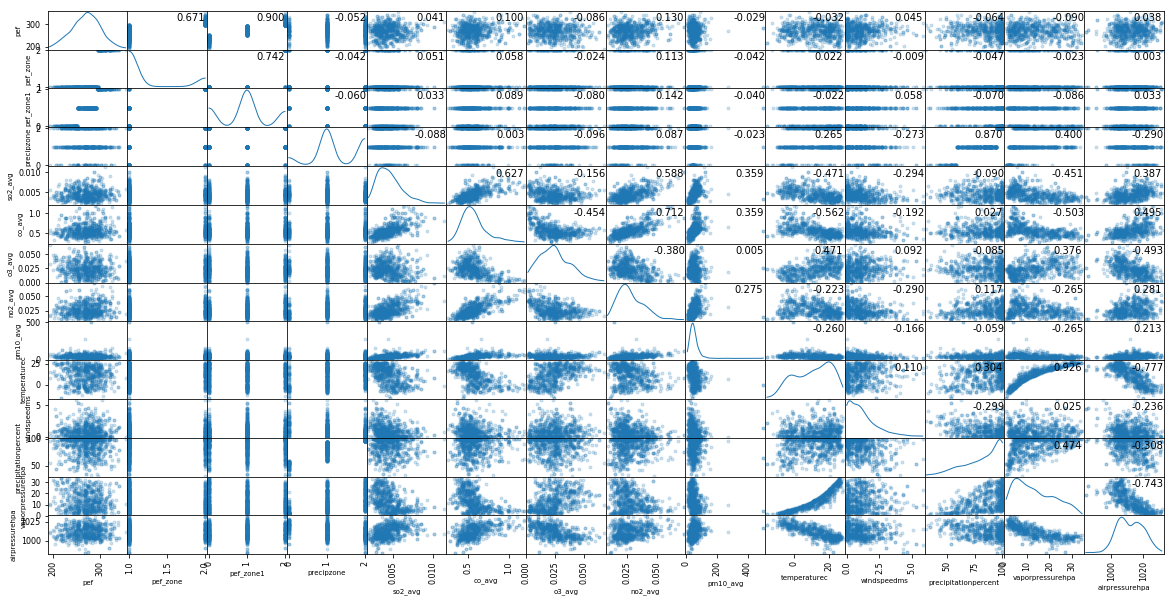

In [4]:
plotScatter = True
if (plotScatter):
    axes=scatter_matrix(dfAMq, alpha=0.2, diagonal='kde', figsize=(20, 10)); # diagonal can be 'hist';
    corr = dfAMq.corr().as_matrix()
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')


In [13]:
HIGHCHARTS_SCRIPTS = """
<script src="//code.highcharts.com/stock/highstock.js"></script>
<script src="//code.highcharts.com/highcharts-more.js"></script>
<script src="//code.highcharts.com/modules/exporting.js"></script>

<style>
.container1 {
    position: relative;
    width: 100%;
    background: white;
    overflow: hidden; /*To get your parent to respect the floated divs*/
}

.dash {
    position: relative;
    width: 50% !important; /*Because you only have 3 elements (100 divided by 3)*/
    height: 250px;
    float: left; /*To get them next to each other if all else fails*/
    background: #eeeeee;
    margins: 100px;
    padding: 10px;
    border: 1px solid gray;
}
</style>

<div class="container1">
    <div id="chart1" class="dash">Div One</div> 
    <div id="chart2" class="dash">Div Two</div>
</div>
"""


display(HTML(HIGHCHARTS_SCRIPTS))

In [19]:
ddf=dfAMq;
PlotHCts(ddf,  ddf.index, 'temperaturec windspeedms precipitationpercent vaporpressurehpa pef_zone'.split(' '), div='chart1', ctype='line', title="Sample Chart for "+ patient );
PlotHCts(ddf,  ddf.index, 'pef_zone pef_zone1'.split(' '), div='chart2', ctype='line', title="Sample Chart for "+ patient );

## SCHAS PEF Predictions start here - Start with Naive Markov

We will use pefzone as we clasified and precipzone as aditional variable for higher order multivariate Markov Chain predictions

In [7]:
X=[dfAMp.pef_zone.values, dfAMp.precipzone.values]
X1=[dfAMp.pef_zone1.values, dfAMp.precipzone.values]

In [8]:
def runNaiveMarkov(s1, order = 1, msg=None):
#    m=NaiveMarkov(' ', order)
    m=NaiveMarkov(X=[s1], nStates=6, order=order, delim=' ', n=len(s1))
    m.fit(s1)
    start = tuple([s1[i] for i in range(order)])
    #r = m.Predict(start )
    #NaiveMarkov.Score(s1, r, True, msg="For MC order = {}".format(order))
    r = m.PredictFromList(s1 )
    m.Score(s1, r, msg=msg);

for order in range(1,10,2):
    runNaiveMarkov(X[0], order, "For MC: with seeds taken from original fit tuples Order: {}".format(order))

=======================Metrics :  For MC: with seeds taken from original fit tuples Order: 1
orig=>[1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1]
pred=>[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
Total 657, correct 482, acc: 0.73
class:1 total:530, correct:450, accuracy:0.8490566037735849
class:2 total:127, correct:32, accuracy:0.25196850393700787
=======================Metrics :  For MC: with seeds taken from original fit tuples Order: 3
orig=>[1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1]
pred=>[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1

In [9]:
for order in range(1,10,2):
    runNaiveMarkov(X1[0], order, "For MC: with seeds taken from original fit tuples Order: {}".format(order))

=======================Metrics :  For MC: with seeds taken from original fit tuples Order: 1
orig=>[1 1 0 1 1 1 1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0]
pred=>[1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 0, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 2, 0]
Total 657, correct 274, acc: 0.42
class:0 total:174, correct:68, accuracy:0.39080459770114945
class:1 total:341, correct:165, accuracy:0.4838709677419355
class:2 total:142, correct:41, accuracy:0.2887323943661972
=======================Metrics :  For MC: with seeds taken from original fit tuples Order: 3
orig=>[1 1 0 1 1 1 1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0]
pred=>[1, 1, 0, 0,

## SCHAS PEF Predictions start here - Now with Weighted Higher Order Multi Variate Markov 


In [21]:
# First print out the fiorst series accuracy and predictions - for ex: PEF predictions
# Second prints out the predictions for seconds series - ex: precipitation and so on ...
#
#
def runHOMVMarkov(X, nStates=3, order=15, msg=None):
    s=len(X)  # => Number of series

    hm = WeightedHOMVMarkov(X, nStates, order)
    f, p, x = hm.fit();
    #h.Dump()
    c,A,b = hm.PrepareMatrices()
    #hm.DisplayCAb(0)
    #hm.DisplayCAb(1)`
    #print ("c=", c, "\nA=\n", A, "\nb=", b)
    sol = hm.Solve(False)
    hm.DumpSolution();

    ac=hm.SelfEval(msg=msg, scoreFirstOnly=False);
    #hm.Score(ac[:,0], X[0][1:],  msg="Test");
    return ac;
    
for order in range(2,12,4):
    P= runHOMVMarkov(X, 3, order, msg="Original PEF: Order="+str(order))
    #break;
P

<IPython.core.display.Math object>

<IPython.core.display.Math object>

0 [ 0.    0.86  0.14] 1 1
1 [ 0.1   0.52  0.37] 1 2
=======================Metrics :  Original PEF: Order=2
orig=>[1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1 1 2]
pred=>[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total 655, correct 528, acc: 0.81
class:1 total:528, correct:528, accuracy:1.0
class:2 total:127, correct:0, accuracy:0.0
=======================Metrics :  Original PEF: Order=2
orig=>[1 2 2 0 0 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 0 1 1 0 0 1 1 2 2 1 1 1 0 1 2 0 0 1 1 1 1 1 1 2 0 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 1 1 0 0]
pred=>[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total 655, correct 342, acc: 0.52
class:0 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

0 [ 0.    0.86  0.14] 1 1
1 [ 0.1   0.52  0.37] 1 1
=======================Metrics :  Original PEF: Order=6
orig=>[1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1 1 2 1 2 1 1]
pred=>[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total 651, correct 524, acc: 0.80
class:1 total:524, correct:524, accuracy:1.0
class:2 total:127, correct:0, accuracy:0.0
=======================Metrics :  Original PEF: Order=6
orig=>[0 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 0 1 1 0 0 1 1 2 2 1 1 1 0 1 2 0 0 1 1 1 1 1 1 2 0 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 1 1 0 0 1 1 1 2]
pred=>[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total 651, correct 341, acc: 0.52
class:0 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

0 [ 0.    0.86  0.14] 1 2
1 [ 0.1   0.52  0.37] 1 1
=======================Metrics :  Original PEF: Order=10
orig=>[1 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 2 2]
pred=>[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total 647, correct 520, acc: 0.80
class:1 total:520, correct:520, accuracy:1.0
class:2 total:127, correct:0, accuracy:0.0
=======================Metrics :  Original PEF: Order=10
orig=>[2 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 0 1 1 0 0 1 1 2 2 1 1 1 0 1 2 0 0 1 1 1 1 1 1 2 0 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 1 1 0 0 1 1 1 2 2 2 1 2]
pred=>[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total 647, correct 338, acc: 0.52
class:

array([[1, 1],
       [1, 1],
       [1, 1],
       ..., 
       [1, 1],
       [1, 1],
       [1, 1]])

In [17]:
for order in range(2,12,4):
    runHOMVMarkov(X1, 3, order, msg="Our way of splitting PEF: Order="+str(order))
    #break;

<IPython.core.display.Math object>

<IPython.core.display.Math object>

0 [ 0.19  0.62  0.18] 1 1
1 [ 0.11  0.57  0.32] 1 2
=======================Metrics :  Our way of splitting PEF: Order=2
orig=>[0 1 1 1 1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0 2 2]
pred=>[1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Total 655, correct 374, acc: 0.57
class:0 total:174, correct:97, accuracy:0.5574712643678161
class:1 total:339, correct:277, accuracy:0.8171091445427728
class:2 total:142, correct:0, accuracy:0.0
=======================Metrics :  Our way of splitting PEF: Order=2
orig=>[1 2 2 0 0 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 0 1 1 0 0 1 1 2 2 1 1 1 0 1 2 0 0 1 1 1 1 1 1 2 0 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 1 1 0 0]
pred=>[1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

<IPython.core.display.Math object>

<IPython.core.display.Math object>

0 [ 0.19  0.62  0.18] 1 1
1 [ 0.11  0.57  0.32] 1 1
=======================Metrics :  Our way of splitting PEF: Order=6
orig=>[1 1 1 1 0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0 2 2 1 2 0 1]
pred=>[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]
Total 651, correct 372, acc: 0.57
class:0 total:173, correct:97, accuracy:0.5606936416184971
class:1 total:336, correct:275, accuracy:0.8184523809523809
class:2 total:142, correct:0, accuracy:0.0
=======================Metrics :  Our way of splitting PEF: Order=6
orig=>[0 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 0 1 1 0 0 1 1 2 2 1 1 1 0 1 2 0 0 1 1 1 1 1 1 2 0 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 1 1 0 0 1 1 1 2]
pred=>[1 1 1 1 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

<IPython.core.display.Math object>

<IPython.core.display.Math object>

0 [ 0.19  0.62  0.18] 1 2
1 [ 0.11  0.57  0.32] 1 1
=======================Metrics :  Our way of splitting PEF: Order=10
orig=>[0 2 1 2 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 0 2 2 1 2 0 1 1 2 2 2]
pred=>[1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Total 647, correct 368, acc: 0.57
class:0 total:173, correct:97, accuracy:0.5606936416184971
class:1 total:332, correct:271, accuracy:0.8162650602409639
class:2 total:142, correct:0, accuracy:0.0
=======================Metrics :  Our way of splitting PEF: Order=10
orig=>[2 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 0 1 1 0 0 1 1 2 2 1 1 1 0 1 2 0 0 1 1 1 1 1 1 2 0 2 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 1 1 0 0 1 1 1 2 2 2 1 2]
pred=>[1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1